# Como resolver problemas envolvendo Processamento de Linguagem Natural (Natural Language Processing) utilizando Aprendizado de Máquina (Machine Learning).

Dados textuais estão em toda parte e você como empresa ou alguém que esteja trabalhando para lançar um novo produto, pode utizá-los para validar, melhorar e expandir esses produtos. A ciência que extrai significado e aprendizado de dados textuais disponíveis no mundo é chamada de Processamento de Linguagem Natural (NLP).

NLP produz novos e incríveis resultados diariamente. Além disso, vem sendo estudada e praticada em grande escala. No entanto, a maior parte dos problemas, e não menos importantes, são colocados em prática com maior frequência em relação a outros:

    - Identificar diferentes grupos de usuários/clientes (ex. predizer rotatividade, tempo de vida, preferência de produtos, etc.);
    - Detectar e extrair com precisão diferentes categorias de um feedback (ex. reviews positivos e negativos, menções a   determinadas características e atributos, etc.);
    - Classificação textual de acordo com uma intenção (ex. se alguém está requisitando ajuda, se está tendo um problema urgente, se uma notícia é falsa ou verdadedaira, etc.).
    
Mesmo existindo vários artigos e tutoriais online sobre o tema, é difícil encontrar material e dicas de como tratar problemas que envolvem NLP, de forma eficiente, partindo do zero. Sendo assim, este guia irá auxiliar na construção de soluções que envolvem Aprendizado de Máquina (ML). Além disso, depois de acomnpanhar estas orientações, será possível:

    - Coletar, preparar e inspecionar dados;
    - Construir modelos preditivos simples;
    - Interpretar e entender seus modelos, certinfcando-se que ele está aprendendo informações relevantes e não ruído.

Este guia foi construido partindo de uma tradução livre do workshoop disponibilizado por Emmanuel Ameisen em:

https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e
https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

Todos os direitos reservados ao autor. Meu objetivo é disponibilizar material de qualidade em lingua portuguesa para impulsionar o ecosistema em torno da temática em questão.

# Coletando dados

Todo problema em ML começa com dados, como uma lista de e-mails, postagens em redes sociais ou chats. Algumas fontes são comuns:

    - Revisão de produtos (Amazon, Yelp e App Stores);
    - Conteúdo gerado por usuários (Tweets, Facebook e StackOverflow);
    - Solução de problemas (solicitação de clientes, abertura de chamados, informações de bate-papo).
    
Os dados utilizados neste guia, são dados disponibilizados pela Figure Eight (https://www.figure-eight.com/). O conjunto de dados é chamado de "Disasters on Social Media" e possui mais de 10.000 tweets que foram selecionados a partir de buscas envolvendo chaves como "em chamas", "quarentena" e "pandemônio", relacionando posteriormente o resultado dessas buscas com eventos realmente desastrosos e não-desastrosos.

A tarefa a ser realizada nestes dados, é identificar um tweet realmente relevante em relação a um desastre. Uma aplicação para a solução que será desenvolvida aqui, em potêncial, seria avisar aos bombeiros sobre um desastre que realmente está acontecendo de rapidamente. No entanto, realizar este procedimento contornando uma publicação referente a um filme de ação, por exemplo, que pode conter as mesmas palavras chaves relacionadas com um desatre.

A seguir a importação das bibliotecas úteis para o desenvolvimento do guia.

In [1]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import itertools
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import gensim

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix



Using TensorFlow backend.


# Limpando os dados

O primeiro passo é saber examinar os dados para, posteriormente, limpá-los. Um conjunmto de dados limpo permitirá que um modelo aprenda apenas recusros signifivamente relevantes e não se adeque a ruídos. Ruídos são características do texto que não são significativos para caracterizar o que se pretende avaliar. No exemplo dos tweets, a hashtag (#) usada para compor determinadas palavras em nada caracteriza o texto propriamente dito. Outras caracteríisticas que precisam ser consideradas na limpeza dos dados são:

    - Remover caracteteres irrelevantes como os não alfanuméricos;
    - Remover palavras que não são relevantes, como as menções indicadas com "@";
    - Converter termos para minúsculos, homogeneizando os dados (OLÁ - olá);
    - Combinar palavras escritas incorretamente para uma única representação (legaaalll - legal);
    - Considerar lematização (reduzir palavras como "sou", "é" para uma forma desflexionada como "ser");
    - Quebrar o seu texto em termos.

Após considerar as opções de limpeza acima, é possível começar a usar os dados para treinar um modelo de predição.

A seguir o código de limpeza dos dados que, na sequência, serão utilizados para treinar o modelo.

In [2]:
# Inspecionando os dados
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv")
questions.columns=['text', 'choose_one', 'class_label']

Dados sujos:

In [3]:
#Primeiras linhas
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [4]:
#Últimas linhas
questions.tail()

,text,choose_one,class_label
10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,Relevant,1
10872,Police investigating after an e-bike collided ...,Relevant,1
10873,The Latest: More Homes Razed by Northern Calif...,Relevant,1
10874,MEG issues Hazardous Weather Outlook (HWO) htt...,Relevant,1
10875,#CityofCalgary has activated its Municipal Eme...,Relevant,1


Estatística descritiva:

In [5]:
questions.describe()

,class_label
count,10876.000000
mean,0.432604
std,0.498420
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


Método de limpeza:

In [6]:
# Expressões regulares para limpeza dos dados
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [7]:
#Limpeza e regravação do arquivo de saída limpo
clean_questions = standardize_text(questions, "text")

clean_questions.to_csv("clean_data.csv")

Dados limpos:

In [8]:
#Primeiras linhas
clean_questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [9]:
#Últimas linhas
clean_questions.tail()

,text,choose_one,class_label
10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,1
10872,police investigating after an e bike collided ...,Relevant,1
10873,the latest more homes razed by northern calif...,Relevant,1
10874,meg issues hazardous weather outlook (hwo),Relevant,1
10875,cityofcalgary has activated its municipal eme...,Relevant,1


Distribuição das classes:

In [10]:
clean_questions.groupby("class_label").count()

,text,choose_one
class_label,,
0,6187,6187
1,4673,4673
2,16,16


É possível obervar que os dados apresentam leve desbalanceamento, com elevação da classe "Not Relevante".

# Quebrando os dados

Agora que temos os dados limpos, vamos transformá-los para que o modelo possa entender. Logo:

    - Quebrar as sentenças em listas de palavras separadas;
    - Dividir os dados para treinamento e teste do modelo;
    - Inspecionar os dados novamente.

In [11]:
from nltk.tokenize import RegexpTokenizer

# Método de quebra dos dados
tokenizer = RegexpTokenizer(r'\w+')

# Gerando listas de sentenças quebradas
clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)

In [12]:
#Primeiras linhas
clean_questions.head()

,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [13]:
#Últimas linhas
clean_questions.tail()

,text,choose_one,class_label,tokens
10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,1,"[m1, 94, 01, 04, utc, 5km, s, of, volcano, haw..."
10872,police investigating after an e bike collided ...,Relevant,1,"[police, investigating, after, an, e, bike, co..."
10873,the latest more homes razed by northern calif...,Relevant,1,"[the, latest, more, homes, razed, by, northern..."
10874,meg issues hazardous weather outlook (hwo),Relevant,1,"[meg, issues, hazardous, weather, outlook, hwo]"
10875,cityofcalgary has activated its municipal eme...,Relevant,1,"[cityofcalgary, has, activated, its, municipal..."


In [14]:
#Inspecioanndo novamente os dados
all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s Quantidade total de palavras, com um vocabulario de %s" % (len(all_words), len(VOCAB)))
print("Tamanho máximo de uma sentença %s" % max(sentence_lengths))

154724 Quantidade total de palavras, com um vocabulario de 18101
Tamanho máximo de uma sentença 34


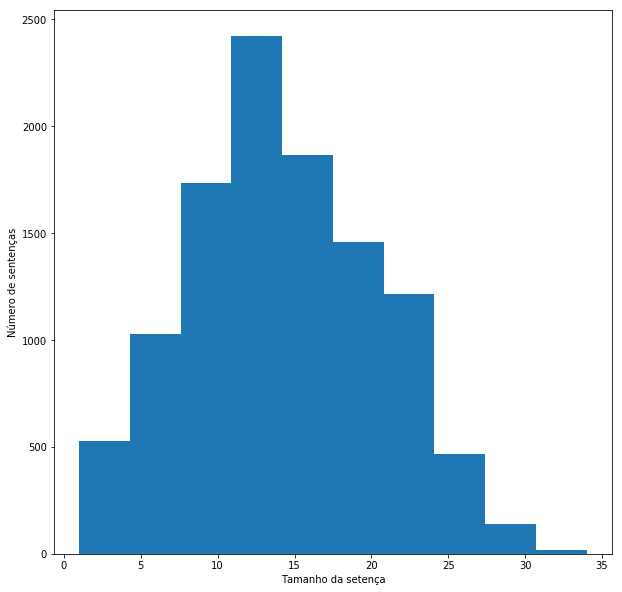

In [15]:
#Distribuilção das sentenças por quantidade de palavras
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Tamanho da setença')
plt.ylabel('Número de sentenças')
plt.hist(sentence_lengths)
plt.show()

Podemos oberservar que a distribuição no tamanho das sentenças tende a normalidade. Essa característica é importante para evitar viés no processo de classificação quanto ao tamanho dos textos avaliados e a quantidade de palavras específicas em uma determinada sentença.

# Processamento de Linguagem Natural e Aprendizado de Máquina

Agora que nossos dados foram lidos e preparados, vamos mergulhar na parte de aprendizado de máquina e processamento de linguagem natural.

Diferentes problemas em Aprendizagem de Máquina possuem diferentes dados de entrada para que seja possível a realização de previsões. Em imagens podemos usar os pixels brutos como entrada, para detecção de fraude em sistemas podemos usar dados referentes ao acesso de clientes e outros recursos disponíveis.

No Processamento de Linguagem Natural não é diferente, precisamos de dados de entrada para realizar as previsões e, esses dados, são as representações textuais do que se pretende avaliar.

No caso deste guia, iremos utilizar as frases (tweets) que foram coletados nos passos anteriores para realizar as predições.

A abordagem mais simples que podemos utilizar é o modelo de mala de palavras ou, como é mais conhecido: bag-of-words. Uma mala de palavras é uma matriz contento uma variação entre 0 e 1 para representar a siginificância de uma palavra em uma determinada setença, em sua abordagem mais simplificada.

Neste guia, usaremos duas abordagens para construção de malas de palavras: Count vectorizer e TF-IDF vectorizer.


# Count Vectorizer

In [16]:
# Construindo bag-of-words com count-vectorizer
count_vectorizer = CountVectorizer()

# Separando o texto da variável alvo
list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

# Construindo exemplos para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
# Aprendendo o vacabulário e contabilizando os termos para teste
X_train_counts = count_vectorizer.fit_transform(X_train)

# Contabilizando os termos no vocabulário aprendido para treino
X_test_counts = count_vectorizer.transform(X_test)


# Visualizando o Vocabulário

Agora que já criamos o vocabulário para treinar o modelo, vamos tentar identificar algum tipo de estrutura semelhante ou agrupamento baseado na variável alvo. No mundo real perfeito, nosso vocabulário seria tão distinto considerando a variável alvo, que estariam distribuidos perfeitamente em grupos separados. A projeção será feita em duas dimensões (LSA).

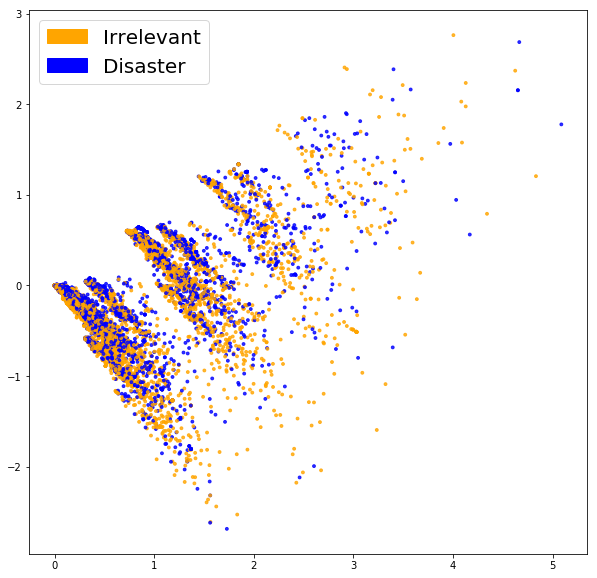

In [17]:
# Método para plotar o gráfico com a distribuição do vocabulário por variável alvo
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})
            
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.show()

Nosso vocabulário não parece muito bem separado em grupos distintos de palavras que explicam a variável alvo. No entanto, vamos ver se é possível construir um modelo útil para lidar com ele.

# Treinando o Classificador

Vamos iniciar com uma regressão logística, visto que, é simples, e muitas vezes resolve o problema. Além disso, é fácil de interpretar.

In [18]:
# Aplicando configurações no modelo
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

#Treinando o modelo com o vocabulário construindo e as variáveis alvo
clf.fit(X_train_counts, y_train)

#Realizando as predições para o conjunto de teste
y_predicted_counts = clf.predict(X_test_counts)

# Avaliando o Classificador

Agora vamos obervar e avaliar algumas métricas para identificar se nosso classificador apresentou um bom desempenho. Para isso, usaremos métricas comumente utilizadas para avaliação de preditores (precisão, cobertura e medida-f).

In [19]:
# Método para extração das métricas de avaliação usando a parte dos dados que separamos para teste.
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.754, precision = 0.752, recall = 0.754, f1 = 0.753


Um classificaro muito bom apresentaria métricas próximas de 1. Logo, para que se aproxime de 1 ou seja exatamente 1, a quantidade de falsos-positivos e falsos-negativos deve ser 0. Avaliando as métricas que exatraímos, podemos obervar que estamos longe disso.

Para analisar especificamente os erros, usaremos outra abordagem bastante conhecido no meio: a matriz de confusão.

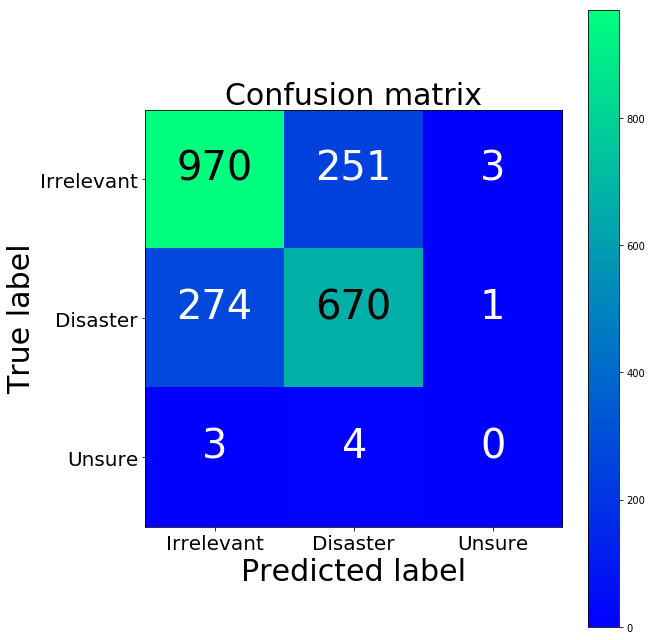

Count Vectorizer confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [20]:
#Método para plotar a matriz de confusão.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(9, 9))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("Count Vectorizer confusion matrix")
print(cm)

Como podemos obervar, nosso classificador, para alguns casos, classifica como incerteza algumas das classes que está tentando predizer. Para nós, isso é pouco relevante. O que mais chama a atenção é ele apontar mais falsos-negativos (textos que remetiam a desastres classificados como não desastrosos) do que falsos-positivos (textos que remetiam a eventos não desastrosos classificados como desastrosos). Dependendo do caso de uso, isso pode ser aceitável. No entanto, pensando no caso de aplicação para avisar os bombeiros, errar qualquer uma das predições pode gerar uma perda grande para a aplicação real da solução.

Vamos realizar uma inspeção adicional para entender quais features (palavras) estão sendo usadas pelo classificador para tomada de decisão.

In [21]:
# Método para identificação das features mais importantes na tomada de decisão.
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

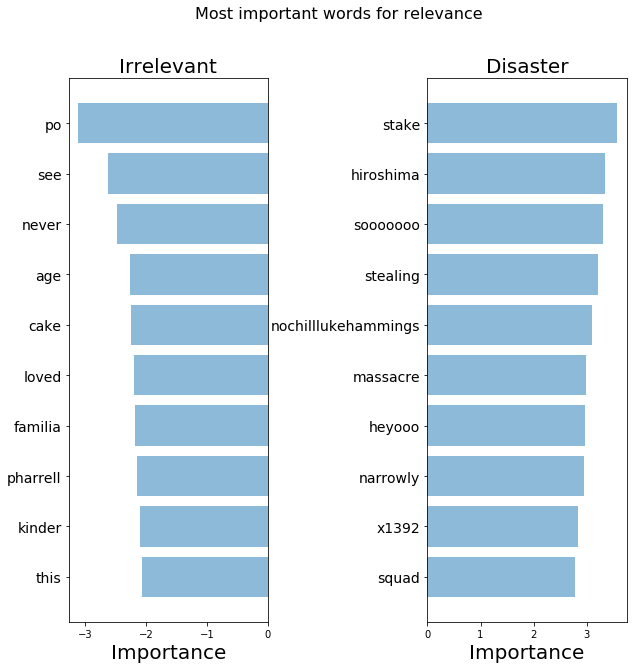

In [22]:
# Método para plotar as featrues mais importantes para cada variável alvo.
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Podemos obervar que nosso classificador capta alguns padrões realmente relevantes e relacionados com desastres e não desastres (ex. hiroshima e descarrilhamento). No entanto, parece estar aprendendo termos irrelevantes para discriminar os fatos (ex. x1392 e heyooo). Esses termos são tratados como ruídos e, quando se aprende ruídos, identificamos o que chamamos de overfitting (super ajuste do modelo).

# TF-IDF Bag of Words

Nesta seção vamos trabalhar com uma abordagem para construção da mala de palavras (bag-of-words) de uma forma mais refinada. Nós iremos usar agora a abordagem TF-IDF (Term Frequency, Inverse Document Frequency), essa abordagem não realiza apenas a contabilização dos termos, unicamente, pela quantidade de vezes em que ele aparece, mas também leva em consideração em quantos textos ele aparece individualmente.

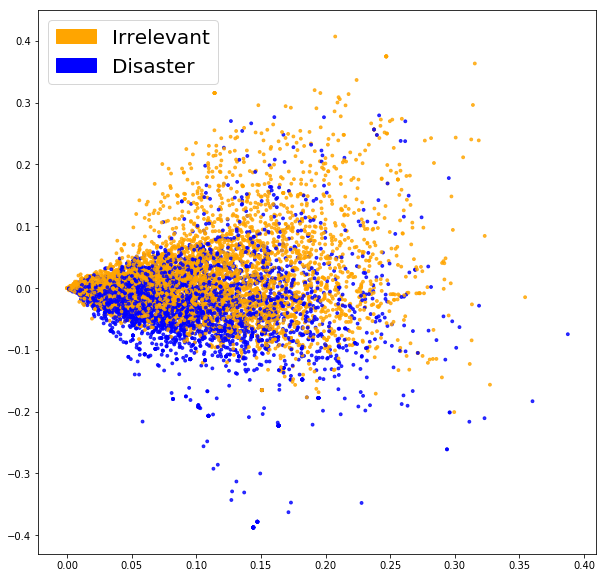

In [23]:
# Construindo bag-of-words com count-vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Aprendendo o vacabulário e contabilizando os termos para teste
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Contabilizando os termos no vocabulário aprendido para treino
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Plotando a distribuição do vocabulário
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

Obervando o gráfico acima, podemos perceber que a nova abordagem agrupou os dados melhor que a abordagem anterior. Vamos ver se isso impacta na capacidade de predição do classificador?

In [ ]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

#Treinando o modelo com o vocabulário construindo e as variáveis alvo
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.762, precision = 0.760, recall = 0.762, f1 = 0.761


Comparando os novos resultados obtidos, por meio da abordagem para contagem de termos TF-IDF, podemos obervar que obtivemos uma pequena melhora na capacidade de predição do modelo considerando as métricas: precisão, cobertura e medida-f.

Vamos analisar a matriz de confusão e entender como os erros estão acontecendo.

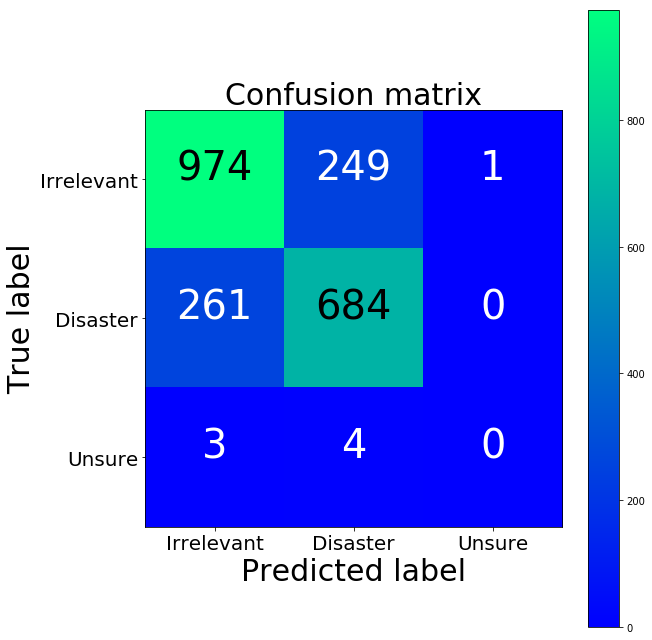

TFIDF confusion matrix
[[974 249   1]
 [261 684   0]
 [  3   4   0]]
BoW confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [ ]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(9, 9))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Podemos observar que tivemos uma redução na quantidade de falsos-positivos e falsos-negativos.

Vamos obervar quais palavras foram consideradas mais importantes para tomada de decisão do novo classificador.

In [ ]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

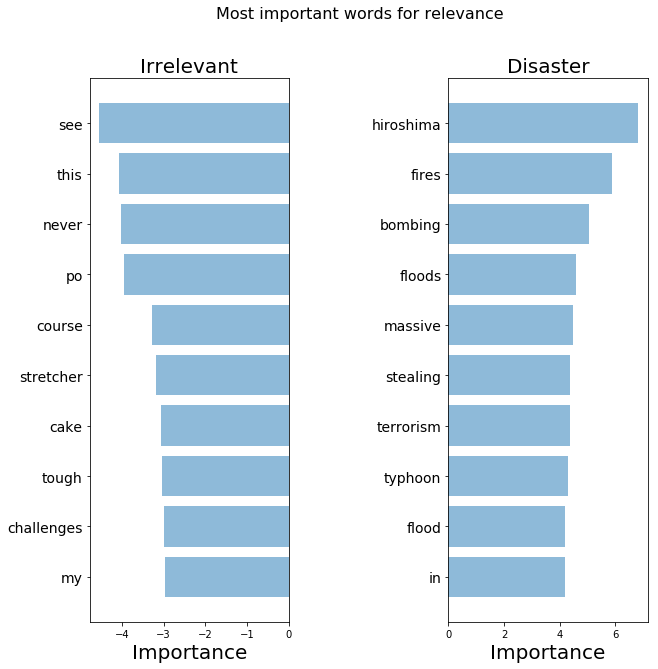

In [ ]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Vemos que a ordem de relevância das palavras mudou bastante e que muitas palavras pouco relevantes para identificar os fatos foram descartadas. Sendo assim, podemos ter mais confiança nos resultados que obtivemos aqui e, também, que realmente obtivemos uma melhora em relação ao processo anterior, embora não tenha sido muito grande.

# Capturando o Significado Semântico das Palavras

Os dois primeiros modelos captam palavras de alta relevância. No entanto, é improvável que qualquer problema de NLP e ML apresente um conjunto de treinamento com todas as palavras realmente relevantes. Para resolver esse problema, é possível capturar o significado semântico das palavras. Ou seja, precisamos entender o grau de relação semântica que as palavras "bom"/"postivo" e "cereja"/"continente" apresentam entre si, por exemplo.

# Usando o Word2vec

O Word2vec é um modelo que foi pré-treinado com um conjunto de dados muito grande e fornece integrações que mapeiam palavras semanticamente relacionadas. Iremos trabalhar com a média das pontuações de similaridade de todas as palavras em nossas sentenças. A ideia da abordagem é que, quanto mais próximas semanticamente elas forem, mais próximo o peso delas será.

In [ ]:
#Treinando a matriz de relação com notícias do Google
#O conjunto de dados para treinar a matriz pode ser acessado em: 
#https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
#Método para calcular a distância semântica entre as palavras
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

#Montagem do arquivo de treinamento contento a relação semântica entre as palavras
def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)

X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels)
plt.show()

Como podemos obervar, nosso vocabulário parece ter sido melhor separado agora. Para os termos com pesos positivos a tendência é ele ser discriminatório para a classe positiva, para os termos com pesos negativos a tendência se inverte. Vamos ver como nosso modelo se comporta agora.

In [ ]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)

clf_w2v.fit(X_train_word2vec, y_train_word2vec)

y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

Analisando as métricas, continuamos melhorando o poder de tomada de decisão do modelo.

In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(9, 9))
plot = plot_confusion_matrix(cm_w2v, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Observando a matriz, nosso modelo é estritamente melhor em todos os aspectos que os dois primeiros.

Por fim, espero que esse guia, mesmo que em uma linguagem mais alto nível, explicando os principais passos tomados, tenha servido de material de apoio para seus estudos sobre NLP e ML.